# Utils

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [2]:
from lab1_utils import train_loop, train_loop_sched, train, test, get_lr
from lab1_utils import multiple_diagnostic, test_class

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

max_epochs = 20
criterion = torch.nn.CrossEntropyLoss()  # input requires logits

Define a basic network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 11 * 11, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # logits
        return x

In [5]:
mod = Net()

print(summary(mod))
print(mod(torch.rand(1, 3, 32, 32)))

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            448
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            495,680
├─Linear: 1-6                            650
├─ReLU: 1-7                              --
Total params: 519,914
Trainable params: 519,914
Non-trainable params: 0
tensor([[ 0.1099, -0.0811,  0.0427, -0.1286, -0.0934,  0.0893, -0.0391, -0.0878,
         -0.0170,  0.1037]], grad_fn=<AddmmBackward0>)


# Exercise 0

In [6]:
# without normalization
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean = torch.zeros(3)  # a mean for each channel, here 1
std = torch.zeros(3)  # a std for each channel, here 1
samples = 0

# simple because we only have one channel, that is greyscale
for X, y in trainloader:
    # width and height over one dimension
    X = torch.flatten(X, 2, 3)
    # [batch_size, 3, 28*28]
    # compute mean and std over each channel then sum and store
    mean += X.mean(2).sum(0)
    std += X.std(2).sum(0)
    samples += X.size(0)

print(f"Samples {samples}")
mean /= samples
print(f"Mean {mean}")
std /= samples
print(f"Std {std}")

Samples 50000
Mean tensor([0.4914, 0.4822, 0.4465])
Std tensor([0.2023, 0.1994, 0.2010])


In [8]:
# normalize data correctly
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# Exercise 1
Learning rate scheduler

In [9]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CosineAnnealingLR

In [10]:
es1_loss_acc = {}  # {"Solver1": [loss, acc]}

## Basic training

In [12]:
model1 = Net()
model1.to(device)

# model1_dict = dict(model=model1, criterion=criterion, device=device, lr=0.001, momentum=0.9,
#                    max_epochs=max_epochs, do_test=True)
# stats = train_loop(trainloader, testloader, **model1_dict)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

es1_loss_acc["SGD"] = [stats[0], stats[3]]

test_class(model1, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9547, Accuracy: 0.30, Runtime: 9.16
Test - Loss: 1.6595, Accuracy: 0.41
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5578, Accuracy: 0.44, Runtime: 8.06
Test - Loss: 1.4479, Accuracy: 0.48
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.3885, Accuracy: 0.50, Runtime: 8.52
Test - Loss: 1.3218, Accuracy: 0.53
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.2792, Accuracy: 0.54, Runtime: 8.29
Test - Loss: 1.2366, Accuracy: 0.56
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.1953, Accuracy: 0.58, Runtime: 8.24
Test - Loss: 1.1561, Accuracy: 0.59
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1200, Accuracy: 0.61, Runtime: 8.23
Test - Loss: 1.0958, Accuracy: 0.61
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0582, Accuracy: 0.63, Runtime: 8.32
Test - Loss: 1.0735, Accuracy: 0.62
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0015, Accuracy: 0.65, Runtime: 8.30
Test - Loss: 1.0354, Accuracy: 0.63


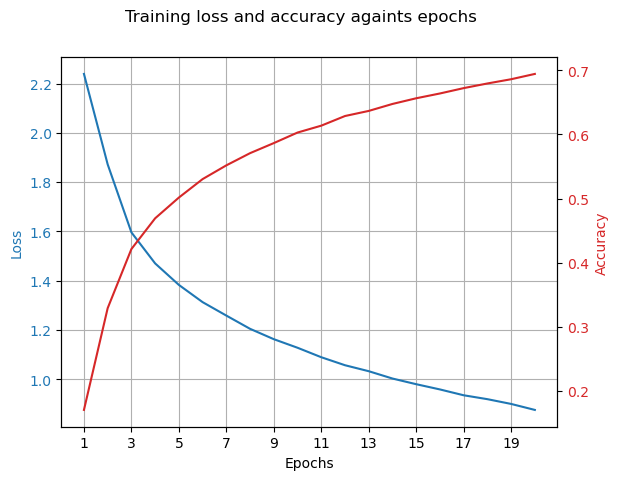

In [29]:
simple_diagnostic(max_epochs, stats[0], stats[1])
plt.savefig("./plots/es1-sgd.pdf")

## Multi-step scheduler

In [15]:
model2 = Net()
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.08, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[3, 10], gamma=0.1)

stats = train_loop_sched(trainloader, testloader, model2, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Step"] = [stats[0], stats[3]]

test_class(model2, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.080000
Training - Loss: 1.9316, Accuracy: 0.28, Runtime: 8.01
Test - Loss: 1.8199, Accuracy: 0.32
Epoch: 2, Learning rate: 0.080000
Training - Loss: 1.8071, Accuracy: 0.33, Runtime: 8.23
Test - Loss: 1.7806, Accuracy: 0.33
Epoch: 3, Learning rate: 0.080000
Training - Loss: 1.7691, Accuracy: 0.35, Runtime: 8.36
Test - Loss: 1.7638, Accuracy: 0.35
Epoch: 4, Learning rate: 0.008000
Training - Loss: 1.5254, Accuracy: 0.44, Runtime: 8.29
Test - Loss: 1.4819, Accuracy: 0.45
Epoch: 5, Learning rate: 0.008000
Training - Loss: 1.3825, Accuracy: 0.49, Runtime: 8.19
Test - Loss: 1.4020, Accuracy: 0.48
Epoch: 6, Learning rate: 0.008000
Training - Loss: 1.2801, Accuracy: 0.54, Runtime: 8.23
Test - Loss: 1.3520, Accuracy: 0.51
Epoch: 7, Learning rate: 0.008000
Training - Loss: 1.1933, Accuracy: 0.57, Runtime: 8.17
Test - Loss: 1.3374, Accuracy: 0.52
Epoch: 8, Learning rate: 0.008000
Training - Loss: 1.1177, Accuracy: 0.60, Runtime: 8.37
Test - Loss: 1.3389, Accuracy: 0.53


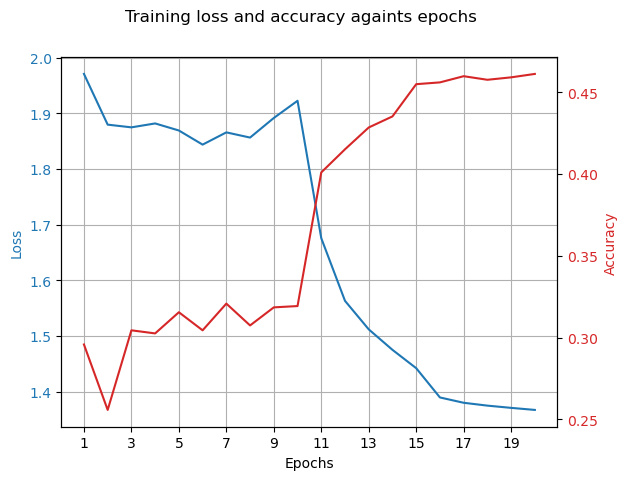

In [35]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-step.pdf")

## Exponential scheduler

In [17]:
model3 = Net()
model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.95)  # a_k *= 0.95**k

stats = train_loop_sched(trainloader, testloader, model3, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Exp"] = [stats[0], stats[3]]

test_class(model3, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.5443, Accuracy: 0.44, Runtime: 8.04
Test - Loss: 1.2274, Accuracy: 0.56
Epoch: 2, Learning rate: 0.009500
Training - Loss: 1.1036, Accuracy: 0.61, Runtime: 8.56
Test - Loss: 1.0186, Accuracy: 0.64
Epoch: 3, Learning rate: 0.009025
Training - Loss: 0.9075, Accuracy: 0.68, Runtime: 8.24
Test - Loss: 0.9208, Accuracy: 0.68
Epoch: 4, Learning rate: 0.008574
Training - Loss: 0.7762, Accuracy: 0.73, Runtime: 8.23
Test - Loss: 0.9264, Accuracy: 0.69
Epoch: 5, Learning rate: 0.008145
Training - Loss: 0.6497, Accuracy: 0.77, Runtime: 8.24
Test - Loss: 0.9156, Accuracy: 0.70
Epoch: 6, Learning rate: 0.007738
Training - Loss: 0.5256, Accuracy: 0.81, Runtime: 8.29
Test - Loss: 1.0629, Accuracy: 0.67
Epoch: 7, Learning rate: 0.007351
Training - Loss: 0.4158, Accuracy: 0.85, Runtime: 8.25
Test - Loss: 1.1230, Accuracy: 0.68
Epoch: 8, Learning rate: 0.006983
Training - Loss: 0.3096, Accuracy: 0.89, Runtime: 8.19
Test - Loss: 1.1265, Accuracy: 0.69


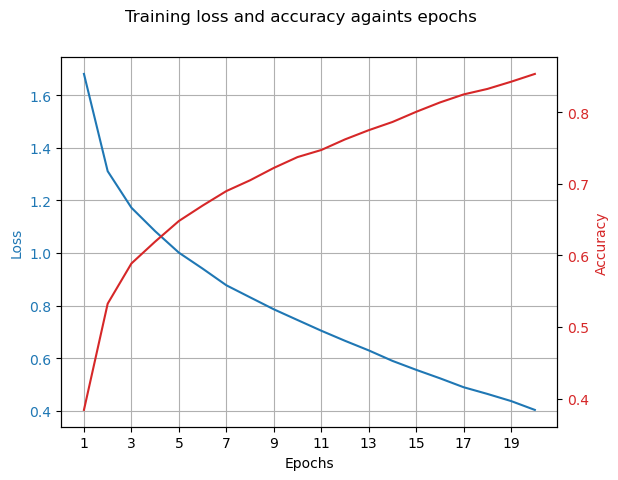

In [51]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-exp.pdf")

## Adam

In [21]:
model4 = Net()
model4.to(device)

optimizer = optim.Adam(model4.parameters(), lr=0.01)

stats = train_loop_sched(trainloader, testloader, model4, criterion, device,
                         optimizer, max_epochs=max_epochs)

es1_loss_acc["Adam"] = [stats[0], stats[3]]

test_class(model4, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.8064, Accuracy: 0.33, Runtime: 8.45
Test - Loss: 1.6172, Accuracy: 0.41
Epoch: 2, Learning rate: 0.010000
Training - Loss: 1.6163, Accuracy: 0.41, Runtime: 8.57
Test - Loss: 1.6284, Accuracy: 0.40
Epoch: 3, Learning rate: 0.010000
Training - Loss: 1.5564, Accuracy: 0.44, Runtime: 8.18
Test - Loss: 1.5180, Accuracy: 0.44
Epoch: 4, Learning rate: 0.010000
Training - Loss: 1.5174, Accuracy: 0.45, Runtime: 8.56
Test - Loss: 1.5607, Accuracy: 0.44
Epoch: 5, Learning rate: 0.010000
Training - Loss: 1.4913, Accuracy: 0.46, Runtime: 8.48
Test - Loss: 1.5255, Accuracy: 0.45
Epoch: 6, Learning rate: 0.010000
Training - Loss: 1.4821, Accuracy: 0.47, Runtime: 8.21
Test - Loss: 1.5162, Accuracy: 0.45
Epoch: 7, Learning rate: 0.010000
Training - Loss: 1.4679, Accuracy: 0.47, Runtime: 8.25
Test - Loss: 1.5740, Accuracy: 0.44
Epoch: 8, Learning rate: 0.010000
Training - Loss: 1.4571, Accuracy: 0.47, Runtime: 8.51
Test - Loss: 1.4977, Accuracy: 0.46


## Cosine annealing

In [19]:
model5 = Net()
model5.to(device)

optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

stats = train_loop_sched(trainloader, testloader, model5, criterion, device,
                         optimizer, scheduler, max_epochs=max_epochs)

es1_loss_acc["SGD-Cos"] = [stats[0], stats[3]]

test_class(model5, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.5114, Accuracy: 0.45, Runtime: 8.23
Test - Loss: 1.2092, Accuracy: 0.57
Epoch: 2, Learning rate: 0.009973
Training - Loss: 1.1073, Accuracy: 0.61, Runtime: 8.21
Test - Loss: 1.0639, Accuracy: 0.63
Epoch: 3, Learning rate: 0.009891
Training - Loss: 0.9280, Accuracy: 0.67, Runtime: 8.22
Test - Loss: 0.9881, Accuracy: 0.66
Epoch: 4, Learning rate: 0.009755
Training - Loss: 0.7839, Accuracy: 0.72, Runtime: 8.46
Test - Loss: 0.9265, Accuracy: 0.68
Epoch: 5, Learning rate: 0.009568
Training - Loss: 0.6662, Accuracy: 0.76, Runtime: 8.23
Test - Loss: 0.9222, Accuracy: 0.70
Epoch: 6, Learning rate: 0.009330
Training - Loss: 0.5400, Accuracy: 0.81, Runtime: 8.16
Test - Loss: 1.0185, Accuracy: 0.67
Epoch: 7, Learning rate: 0.009045
Training - Loss: 0.4361, Accuracy: 0.84, Runtime: 8.18
Test - Loss: 1.0486, Accuracy: 0.68
Epoch: 8, Learning rate: 0.008716
Training - Loss: 0.3208, Accuracy: 0.88, Runtime: 8.08
Test - Loss: 1.2190, Accuracy: 0.68


## Show optimizers performance

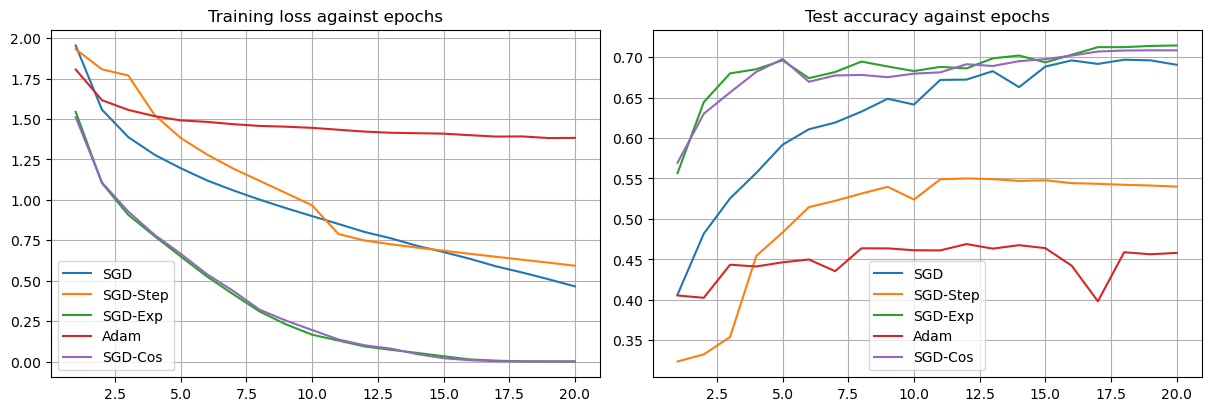

In [22]:
multiple_diagnostic(es1_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-opt-diagnostic.pdf")

# Excercise 2

In [10]:
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [9]:
es2_loss_acc = {}

In [31]:
es2_loss_acc["SGD"] = es1_loss_acc["SGD"]

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


### Random affine transforms

In [16]:
transf1 = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf1)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size, shuffle=True, num_workers=2)

In [17]:
model_transf = Net()
model_transf.to(device)

model_transf_dict = dict(model=model_transf, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                         max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader_1, testloader, **model_transf_dict)

es2_loss_acc["RandAff"] = [stats[0], stats[3]]

test_class(model_transf, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.0623, Accuracy: 0.24, Runtime: 8.97
Test - Loss: 1.7798, Accuracy: 0.36
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.7337, Accuracy: 0.37, Runtime: 8.37
Test - Loss: 1.5360, Accuracy: 0.45
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.5870, Accuracy: 0.43, Runtime: 8.51
Test - Loss: 1.5151, Accuracy: 0.45
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.5073, Accuracy: 0.46, Runtime: 8.50
Test - Loss: 1.3689, Accuracy: 0.51
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.4465, Accuracy: 0.48, Runtime: 8.62
Test - Loss: 1.2940, Accuracy: 0.54
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.3921, Accuracy: 0.50, Runtime: 8.39
Test - Loss: 1.2199, Accuracy: 0.57
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.3340, Accuracy: 0.52, Runtime: 8.46
Test - Loss: 1.1820, Accuracy: 0.58
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.2887, Accuracy: 0.54, Runtime: 8.47
Test - Loss: 1.1715, Accuracy: 0.58


### Random horizontal flip transforms

In [19]:
transf2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True, num_workers=2)

In [20]:
model_transf = Net()
model_transf.to(device)

model_transf_dict = dict(model=model_transf, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                         max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader_2, testloader, **model_transf_dict)

es2_loss_acc["HorizFlip"] = [stats[0], stats[3]]

test_class(model_transf, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.0119, Accuracy: 0.27, Runtime: 7.52
Test - Loss: 1.7696, Accuracy: 0.36
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.6097, Accuracy: 0.42, Runtime: 7.31
Test - Loss: 1.4635, Accuracy: 0.47
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.4156, Accuracy: 0.49, Runtime: 7.33
Test - Loss: 1.3614, Accuracy: 0.52
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.3097, Accuracy: 0.53, Runtime: 7.29
Test - Loss: 1.2718, Accuracy: 0.55
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.2172, Accuracy: 0.57, Runtime: 7.33
Test - Loss: 1.1690, Accuracy: 0.59
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1395, Accuracy: 0.60, Runtime: 7.31
Test - Loss: 1.1123, Accuracy: 0.61
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0706, Accuracy: 0.62, Runtime: 7.36
Test - Loss: 1.0660, Accuracy: 0.63
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0097, Accuracy: 0.65, Runtime: 7.32
Test - Loss: 1.0286, Accuracy: 0.64


### Gaussian blur transforms

In [21]:
transf3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf3)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size, shuffle=True, num_workers=2)

In [22]:
model_transf = Net()
model_transf.to(device)

model_transf_dict = dict(model=model_transf, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                         max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader_3, testloader, **model_transf_dict)

es2_loss_acc["Blur"] = [stats[0], stats[3]]

test_class(model_transf, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9855, Accuracy: 0.29, Runtime: 15.67
Test - Loss: 1.7191, Accuracy: 0.38
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5689, Accuracy: 0.44, Runtime: 15.14
Test - Loss: 1.4831, Accuracy: 0.46
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.4284, Accuracy: 0.49, Runtime: 15.12
Test - Loss: 1.3822, Accuracy: 0.50
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.3352, Accuracy: 0.53, Runtime: 15.35
Test - Loss: 1.2706, Accuracy: 0.55
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.2542, Accuracy: 0.56, Runtime: 15.22
Test - Loss: 1.2146, Accuracy: 0.57
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1746, Accuracy: 0.59, Runtime: 15.00
Test - Loss: 1.1483, Accuracy: 0.59
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.1079, Accuracy: 0.61, Runtime: 15.44
Test - Loss: 1.0941, Accuracy: 0.61
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0442, Accuracy: 0.63, Runtime: 15.71
Test - Loss: 1.0385, Accurac

### Color jitter

In [23]:
transf4 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset_4 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf4)
trainloader_4 = torch.utils.data.DataLoader(trainset_4, batch_size=batch_size, shuffle=True, num_workers=2)

In [24]:
model_transf = Net()
model_transf.to(device)

model_transf_dict = dict(model=model_transf, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                         max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader_4, testloader, **model_transf_dict)

es2_loss_acc["Jitter"] = [stats[0], stats[3]]

test_class(model_transf, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9865, Accuracy: 0.28, Runtime: 13.45
Test - Loss: 1.6631, Accuracy: 0.40
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.5879, Accuracy: 0.43, Runtime: 13.46
Test - Loss: 1.5093, Accuracy: 0.47
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.4522, Accuracy: 0.48, Runtime: 13.47
Test - Loss: 1.3861, Accuracy: 0.51
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.3628, Accuracy: 0.52, Runtime: 13.34
Test - Loss: 1.3084, Accuracy: 0.53
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.2678, Accuracy: 0.55, Runtime: 13.54
Test - Loss: 1.2061, Accuracy: 0.57
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.1727, Accuracy: 0.59, Runtime: 13.46
Test - Loss: 1.1331, Accuracy: 0.60
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.0984, Accuracy: 0.62, Runtime: 13.71
Test - Loss: 1.0594, Accuracy: 0.63
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.0261, Accuracy: 0.64, Runtime: 13.46
Test - Loss: 1.0440, Accurac

### Show tranforms performance

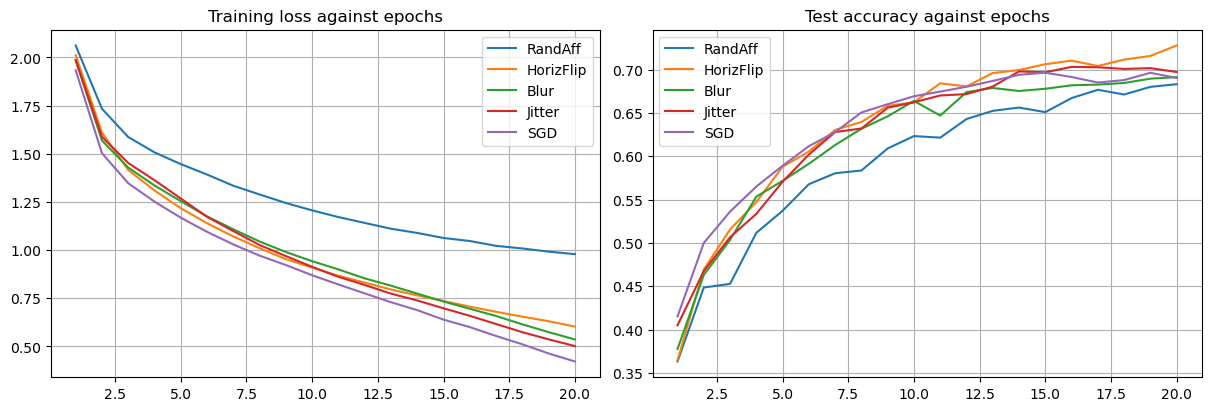

In [32]:
multiple_diagnostic(es2_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-transforms-diagnostic.pdf")

### Show transforms

In [33]:
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [35]:
# plot real and augmented images
from torchvision.utils import make_grid

transf1 = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()])
trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf1)

transf2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])
trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf2)

transf3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),
    transforms.ToTensor()])
trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf3)

transf4 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()])
trainset_4 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transf4)

to_show = 20  # take the first images
imgs = torch.stack((*[non_augmented[i][0] for i in range(to_show)],
                    *[trainset_1[i][0] for i in range(to_show)],
                    *[trainset_2[i][0] for i in range(to_show)],
                    *[trainset_3[i][0] for i in range(to_show)],
                    *[trainset_4[i][0] for i in range(to_show)]))
grid = make_grid(imgs, nrow=to_show)

image = transforms.ToPILImage()(grid)
image.show()
image.save("./plots/transforms.png")

# Exercise 3

Fine-tuning of popular CNNs, use pre-trained as backbone

In [ ]:
import torchvision.models as models

### My Net

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
notransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [10]:
# con troppe trasformazioni va lento perché le applica online
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    # transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor(),
    # transforms.Resize(224),  # for alexnet
    transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize(224),  # for alexnet
     transforms.Normalize(mean, std)])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(20):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, Loss: {loss_k:.4f}, Accuracy: {acc_k:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")
# torch.save(model.state_dict(), 'net_augmented1.pth')

# es1_loss_acc["SGD"] = [losses, accs]

test_class(model, device, criterion, testloader)

Epoch: 0, Loss: 2.2560, Accuracy: 0.15, Runtime: 13.69
Epoch: 1, Loss: 1.9195, Accuracy: 0.31, Runtime: 13.73
Epoch: 2, Loss: 1.6988, Accuracy: 0.39, Runtime: 13.91
Epoch: 3, Loss: 1.5789, Accuracy: 0.44, Runtime: 13.71
Epoch: 4, Loss: 1.5040, Accuracy: 0.46, Runtime: 13.76
Epoch: 5, Loss: 1.4401, Accuracy: 0.49, Runtime: 13.66
Epoch: 6, Loss: 1.3854, Accuracy: 0.51, Runtime: 13.72
Epoch: 7, Loss: 1.3348, Accuracy: 0.53, Runtime: 13.64
Epoch: 8, Loss: 1.2886, Accuracy: 0.55, Runtime: 13.61
Epoch: 9, Loss: 1.2479, Accuracy: 0.56, Runtime: 13.58
Epoch: 10, Loss: 1.2126, Accuracy: 0.58, Runtime: 13.71
Epoch: 11, Loss: 1.1827, Accuracy: 0.59, Runtime: 13.62
Epoch: 12, Loss: 1.1538, Accuracy: 0.60, Runtime: 13.63
Epoch: 13, Loss: 1.1251, Accuracy: 0.61, Runtime: 13.63
Epoch: 14, Loss: 1.1103, Accuracy: 0.61, Runtime: 13.63
Epoch: 15, Loss: 1.0878, Accuracy: 0.62, Runtime: 13.57
Epoch: 16, Loss: 1.0643, Accuracy: 0.63, Runtime: 13.61
Epoch: 17, Loss: 1.0469, Accuracy: 0.64, Runtime: 13.62
Ep

### Train AlexNet

In [9]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
alexnet = models.alexnet(weights="DEFAULT")
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)
alexnet.to(device)

# print(f"Trainable parameters: {count_trainable_parameters(alexnet)}")
print(summary(alexnet))

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       23,296
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       307,392
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       663,936
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       884,992
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      590,080
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                   

In [11]:
# freeze all layers
for param in alexnet.parameters():
    param.requires_grad = False

# let final layer be trainable, that goes into classification head
alexnet.classifier[6].weight.requires_grad = True
alexnet.classifier[6].bias.requires_grad = True
# count_trainable_parameters(alexnet)  # 4096 * 10 + 1 (bias)
print(summary(alexnet))

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (23,296)
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       (307,392)
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       (663,936)
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       (884,992)
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      (590,080)
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      (37,752,832)
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17       

In [30]:
alexnet(torch.randn(1, 3, 224, 224).to(device))

tensor([[ 0.1415, -1.8886,  1.2051,  0.5140,  0.9456,  0.8066,  0.8011, -0.4020,
         -0.7322, -1.3658]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

In [15]:
# alexnet_dict = dict(model=alexnet, criterion=criterion, device=device, lr=0.001, momentum=0.9,
#                     max_epochs=6, do_test=True)
# stats = train_loop(trainloader, testloader, **alexnet_dict)

optimizer = optim.SGD(alexnet.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, testloader, alexnet, criterion,
                         device, optimizer, scheduler, 10)

print("=========")
test_class(alexnet, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.100000
Training - Loss: 18.2388, Accuracy: 0.67, Runtime: 33.01
Test - Loss: 15.9258, Accuracy: 0.72
Epoch: 2, Learning rate: 0.080000
Training - Loss: 13.8824, Accuracy: 0.72, Runtime: 32.83
Test - Loss: 10.2712, Accuracy: 0.75
Epoch: 3, Learning rate: 0.064000
Training - Loss: 11.6101, Accuracy: 0.73, Runtime: 39.35
Test - Loss: 7.9852, Accuracy: 0.78
Epoch: 4, Learning rate: 0.051200
Training - Loss: 9.1842, Accuracy: 0.75, Runtime: 44.13
Test - Loss: 8.4048, Accuracy: 0.76
Epoch: 5, Learning rate: 0.040960
Training - Loss: 7.5871, Accuracy: 0.75, Runtime: 37.65
Test - Loss: 5.5323, Accuracy: 0.80
Epoch: 6, Learning rate: 0.032768
Training - Loss: 6.4290, Accuracy: 0.76, Runtime: 37.30
Test - Loss: 5.2637, Accuracy: 0.79
Epoch: 7, Learning rate: 0.026214
Training - Loss: 5.3492, Accuracy: 0.77, Runtime: 37.39
Test - Loss: 4.0667, Accuracy: 0.80
Epoch: 8, Learning rate: 0.020972
Training - Loss: 4.6541, Accuracy: 0.78, Runtime: 36.99
Test - Loss: 4.1000, Ac

### Train VGG16

In [17]:
vgg16 = models.vgg16(weights="DEFAULT")
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 10)
vgg16.to(device)

print(vgg16)
print(summary(vgg16))

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [19]:
# freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# let final layer be trainable, that goes into classification head
vgg16.classifier[6].weight.requires_grad = True
vgg16.classifier[6].bias.requires_grad = True

print(count_trainable_parameters(vgg16))  # 4096 * 10 + 1 (bias)
# print(summary(vgg16))

40970


In [20]:
optimizer = optim.SGD(vgg16.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.8)

stats = train_loop_sched(trainloader, testloader, vgg16, criterion,
                         device, optimizer, scheduler, 10)

print("=========")
test_class(vgg16, device, criterion, testloader, classes)

KeyboardInterrupt: 

### Train ResNet18

In [11]:
from torchvision import models

resnet18 = models.resnet18(weights="DEFAULT")
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18.to(device)
# print(resnet18)

print(summary(resnet18))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [12]:
# freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# let final layer be trainable, that goes into classification head
resnet18.fc.weight.requires_grad = True
resnet18.fc.bias.requires_grad = True
#count_trainable_parameters(resnet18)
print(summary(resnet18))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11   

In [112]:
criterion = nn.CrossEntropyLoss()

resnet18_dict = dict(model=resnet18, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                     max_epochs=6, do_test=True)

stats = train_loop(trainloader, testloader, **resnet18_dict)

print("=========")
test_class(resnet18, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.001000
Training - Loss: 0.6070, Accuracy: 0.80, Runtime: 74.44
Test - Loss: 0.5969, Accuracy: 0.80
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.5941, Accuracy: 0.80, Runtime: 76.44
Test - Loss: 0.5871, Accuracy: 0.80
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.5871, Accuracy: 0.80, Runtime: 76.83
Test - Loss: 0.5826, Accuracy: 0.80
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.5786, Accuracy: 0.80, Runtime: 76.40
Test - Loss: 0.5834, Accuracy: 0.80


KeyboardInterrupt: 

In [113]:
test_class(resnet18, device, criterion, testloader, classes)

Accuracy for class: plane is 79.4 %
Accuracy for class: car   is 91.2 %
Accuracy for class: bird  is 74.4 %
Accuracy for class: cat   is 70.1 %
Accuracy for class: deer  is 75.6 %
Accuracy for class: dog   is 75.9 %
Accuracy for class: frog  is 85.7 %
Accuracy for class: horse is 83.3 %
Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 83.2 %


In [14]:
criterion = nn.CrossEntropyLoss()

resnet18_dict = dict(model=resnet18, criterion=criterion, device=device, lr=0.01, momentum=0.9,
                     max_epochs=10, do_test=True)

stats = train_loop(trainloader, testloader, **resnet18_dict)

print("=========")
test_class(resnet18, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.9464, Accuracy: 0.39, Runtime: 11.16
Test - Loss: 2.0002, Accuracy: 0.38
Epoch: 2, Learning rate: 0.010000
Training - Loss: 1.9667, Accuracy: 0.39, Runtime: 11.25
Test - Loss: 1.9476, Accuracy: 0.41
Epoch: 3, Learning rate: 0.010000
Training - Loss: 1.9510, Accuracy: 0.40, Runtime: 11.12
Test - Loss: 2.0313, Accuracy: 0.40
Epoch: 4, Learning rate: 0.010000
Training - Loss: 1.9518, Accuracy: 0.39, Runtime: 10.99
Test - Loss: 1.9870, Accuracy: 0.39
Epoch: 5, Learning rate: 0.010000
Training - Loss: 1.9582, Accuracy: 0.39, Runtime: 11.16
Test - Loss: 2.0102, Accuracy: 0.39
Epoch: 6, Learning rate: 0.010000
Training - Loss: 1.9671, Accuracy: 0.40, Runtime: 11.29


KeyboardInterrupt: 